In [1]:
import os
import numpy as np
import librosa
import tensorflow as tf
from tensorflow.keras.initializers import GlorotUniform
from tensorflow.keras import regularizers
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import MaxPooling2D, Dropout, Activation, TimeDistributed
from tensorflow.keras.layers import BatchNormalization  # Updated import

from tensorflow.keras.layers import Dense, Input
from tensorflow.keras.layers import Conv2D, Flatten, Lambda 
from tensorflow.keras.layers import LeakyReLU

import numpy as np
from sklearn.model_selection import train_test_split

# Update to TensorFlow 2.x syntax
import keras
from tensorflow.keras.layers import Layer
from tensorflow.keras import backend as K

# Change the import for GlobalAveragePooling1D to GlobalAveragePooling2D
from tensorflow.keras.layers import GlobalAveragePooling2D

In [2]:
# Set your file paths and constants
TRAINING_LABEL = "/data/common_source/datasets/asvpoof-2019-dataset/PA/PA/ASVspoof2019_PA_cm_protocols/ASVspoof2019.PA.cm.train.trn.txt"
TRAINING_DATA = (
    "/data/common_source/datasets/asvpoof-2019-dataset/PA/PA/ASVspoof2019_PA_train/flac"
)
VALIDATION_DATA = (
    "/data/common_source/datasets/asvpoof-2019-dataset/PA/PA/ASVspoof2019_PA_dev/flac"
)
VALIDATION_LABEL = "/data/common_source/datasets/asvpoof-2019-dataset/PA/PA/ASVspoof2019_PA_cm_protocols/ASVspoof2019.PA.cm.dev.trl.txt"
SAMPLE_RATE = 16000  # Adjust if your sample rate is different
DURATION = 3  # Adjust the duration of your audio samples
N_MFCC = 128  # Adjust the number of mel filters
max_time_steps = 300

In [3]:
def preprocess_data(file_path, max_time_steps=300, sample_rate=16000, duration=3, n_mels=128,hop_length=160,win_length=512,n_fft=512):
    audio, _ = librosa.load(file_path, sr=sample_rate, duration=duration)

    # Extract Mel spectrogram using librosa
    mel_spectrogram = librosa.feature.melspectrogram(y=audio, sr=sample_rate, n_mels=n_mels,hop_length=hop_length, win_length=win_length,n_fft=n_fft)
    mel_spectrogram = librosa.power_to_db(mel_spectrogram, ref=np.max)

    # Ensure all spectrograms have the same width (time steps)
    if mel_spectrogram.shape[1] < max_time_steps:
        mel_spectrogram = np.pad(mel_spectrogram, ((0, 0), (0, max_time_steps - mel_spectrogram.shape[1])), mode='constant')
    else:
        mel_spectrogram = mel_spectrogram[:, :max_time_steps]

    return mel_spectrogram

In [4]:
file_path1 = "/data/common_source/datasets/asvpoof-2019-dataset/PA/PA/ASVspoof2019_PA_train/flac/PA_T_0023581.flac"
file_path2 = "/data/common_source/datasets/asvpoof-2019-dataset/PA/PA/ASVspoof2019_PA_train/flac/PA_T_0030329.flac"

lfcc1 = preprocess_data(file_path1)
lfcc2 = preprocess_data(file_path2)

print(lfcc1.shape)
print(lfcc2.shape)

(128, 300)
(128, 300)


In [ ]:
from pydub import AudioSegment
def get_duration_pydub(file_path):
   audio_file = AudioSegment.from_file(file_path)
   duration = audio_file.duration_seconds
   return duration
file_path = '/data/common_source/datasets/asvpoof-2019-dataset/PA/PA/ASVspoof2019_PA_train/flac/PA_T_0023581.flac'
duration = get_duration_pydub(file_path)
print(f"Duration: {duration:.2f} seconds")

In [5]:
# Load labels for training Data
train_labels = {}

with open(TRAINING_LABEL, 'r') as label_file:
    lines = label_file.readlines()

for line in lines:
    parts = line.strip().split()
    file_name = parts[1]
    label = 1 if parts[-1] == "bonafide" else 0
    train_labels[file_name] = label

X = []
y = []

for file_name, label in train_labels.items():
    file_path = os.path.join(TRAINING_DATA, file_name + ".flac")

    # Use the preprocess_data function with max_length
    mel_spectrogram = preprocess_data(file_path)

    X.append(mel_spectrogram)
    y.append(label)

X = np.array(X)
y = np.array(y)


In [6]:
# Print out the shapes for debugging
print("Shape of X before reshape:", X.shape)
print("Shape of y before reshape:", y.shape)

X_reshaped = X.reshape(X.shape[0], X.shape[1], X.shape[2], 1)

print("Shape of X after reshape:", X_reshaped.shape)

Shape of X before reshape: (54000, 128, 300)
Shape of y before reshape: (54000,)
Shape of X after reshape: (54000, 128, 300, 1)


In [7]:
# Load labels for evaluation Data
eval_X = []
eval_y = []

with open(VALIDATION_LABEL, 'r') as eval_label_file:
    eval_lines = eval_label_file.readlines()

eval_labels = {}

for line in eval_lines:
    parts = line.strip().split()
    file_name = parts[1]
    label = 1 if parts[-1] == "bonafide" else 0
    eval_labels[file_name] = label

for file_name, label in eval_labels.items():
    file_path = os.path.join(VALIDATION_DATA, file_name + ".flac")

        # Use the preprocess_data function
    mel_spectrogram = preprocess_data(file_path)

    eval_X.append(mel_spectrogram)
    eval_y.append(label)


eval_X = np.array(eval_X)
eval_y = np.array(eval_y)


In [8]:
# Print out the shapes for debugging
print("Shape of eval_X before reshape:", eval_X.shape)
print("Shape of eval_y before reshape:", eval_y.shape)

eval_X_reshaped = eval_X.reshape(eval_X.shape[0], eval_X.shape[1], eval_X.shape[2], 1)

print("Shape of X after reshape:", eval_X_reshaped.shape)

Shape of eval_X before reshape: (29700, 128, 300)
Shape of eval_y before reshape: (29700,)
Shape of X after reshape: (29700, 128, 300, 1)


In [9]:
def init_weights():
    initializer = GlorotUniform()
    return initializer

In [10]:
def apply_activation(x):
    y = BatchNormalization()(x)
    y = Activation('relu')(y)
    return x

In [11]:
# Define constants
input_shape =   # LFCC features have 13 dimensions

def lcnn_model(input_shape):
    x = Sequential()

    # Convolutional layers
    inputs = Input(shape=input_shape)

    x = Conv2D(16, (5, 5), padding='same', kernel_initializer=init_weights())(inputs)
    x = MaxPooling2D(pool_size=(2,2))(x)

    x = Conv2D(16, (1, 1), padding='same', kernel_initializer=init_weights())(x)
    x = apply_activation(x)
    x = Conv2D(24, (3, 3), padding='same', kernel_initializer=init_weights())(x)
    x = apply_activation(x)
    x = MaxPooling2D(pool_size=(2,2))(x)

    x = Conv2D(32, (1, 1), padding='same', kernel_initializer=init_weights())(x)
    x = apply_activation(x)
    x = Conv2D(32, (3, 3), padding='same', kernel_initializer=init_weights())(x)
    x = apply_activation(x)
    x = MaxPooling2D(pool_size=(2,2))(x)

    x = Conv2D(32, (1, 1), padding='same', kernel_initializer=init_weights())(x)
    x = apply_activation(x)
    x = Conv2D(16, (3, 3), padding='same', kernel_initializer=init_weights())(x)
    x = apply_activation(x)
    x = MaxPooling2D(pool_size=(2,2))(x)


    x = Conv2D(16, (1, 1), padding='same', kernel_initializer=init_weights())(x)
    x = apply_activation(x)
    x = Conv2D(16, (3, 3), padding='same', kernel_initializer=init_weights())(x)
    x = apply_activation(x)
    x = MaxPooling2D(pool_size=(2,2))(x)

    x = Flatten()(x)
    x = Dropout(0.5)(x)
    x = Dense(32, kernel_initializer=init_weights())(x)
    x = apply_activation(x)

    x = Dropout(0.5)(x)
    x = Dense(1,kernel_initializer=init_weights())(x)
    # x = BatchNormalization()(x)
    x = Activation('sigmoid')(x)

    output = Dense(1, activation='sigmoid', kernel_initializer=init_weights())(x)

    model = Model(inputs=inputs, outputs=output)
    return model




In [12]:
model = lcnn_model(input_shape)

# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

2023-11-28 00:38:22.745317: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-11-28 00:38:23.546563: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1532] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 22834 MB memory:  -> device: 0, name: NVIDIA TITAN RTX, pci bus id: 0000:1a:00.0, compute capability: 7.5
2023-11-28 00:38:23.547218: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1532] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 22757 MB memory:  -> device: 1, name: NVIDIA TITAN RTX, pci bus id: 0000:68:00.0, compute capability: 7.5


In [13]:
# Display the model summary
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 128, 300, 1)]     0         
                                                                 
 conv2d (Conv2D)             (None, 128, 300, 16)      416       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 64, 150, 16)      0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 64, 150, 16)       272       
                                                                 
 conv2d_2 (Conv2D)           (None, 64, 150, 24)       3480      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 32, 75, 24)       0         
 2D)                                                         

In [14]:
from tensorflow.keras.callbacks import ModelCheckpoint

# Split the data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X_reshaped, y, test_size=0.2, random_state=42)

# Define a model checkpoint to save the best weights during training
checkpoint = ModelCheckpoint('models/LCNN_with_MEL.h5', monitor='val_loss', save_best_only=True)

In [15]:
# Train the model
history = model.fit(X_train, y_train, validation_data=(eval_X_reshaped, eval_y), epochs=100, batch_size=32, callbacks=[checkpoint])

Epoch 1/100


2023-11-28 00:39:31.399199: I tensorflow/stream_executor/cuda/cuda_dnn.cc:384] Loaded cuDNN version 8600
2023-11-28 00:39:31.917342: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory


1350/1350 [==============================] - 33s 22ms/step - loss: 0.3557 - accuracy: 0.9008 - val_loss: 0.3847 - val_accuracy: 0.8182
Epoch 2/100
1350/1350 [==============================] - 25s 18ms/step - loss: 0.2563 - accuracy: 0.9008 - val_loss: 0.3404 - val_accuracy: 0.8182
Epoch 3/100
1350/1350 [==============================] - 25s 18ms/step - loss: 0.2239 - accuracy: 0.9008 - val_loss: 0.3164 - val_accuracy: 0.8182
Epoch 4/100
1350/1350 [==============================] - 25s 18ms/step - loss: 0.2021 - accuracy: 0.9008 - val_loss: 0.2794 - val_accuracy: 0.8182
Epoch 5/100
1350/1350 [==============================] - 25s 18ms/step - loss: 0.1860 - accuracy: 0.9008 - val_loss: 0.3082 - val_accuracy: 0.8182
Epoch 6/100
1350/1350 [==============================] - 25s 18ms/step - loss: 0.1726 - accuracy: 0.9008 - val_loss: 0.2324 - val_accuracy: 0.8182
Epoch 7/100
1350/1350 [==============================] - 24s 18ms/step - loss: 0.1604 - accuracy: 0.9115 - val_loss: 0.3061 - val_

In [ ]:
# # Evaluate the model on the test set
loss, accuracy = model.evaluate(X_val, y_val)
print(f"Test Loss: {loss:.4f}, Test Accuracy: {accuracy * 100:.2f}%")

# Evaluate the model on the separate evaluation dataset
eval_loss, eval_accuracy = model.evaluate(eval_X_reshaped, eval_y)
print(
    f"Evaluation Loss: {eval_loss:.4f}, Evaluation Accuracy: {eval_accuracy * 100:.2f}%"
)

2023-11-27 14:26:49.628134: W tensorflow/core/common_runtime/bfc_allocator.cc:479] Allocator (GPU_0_bfc) ran out of memory trying to allocate 3.10GiB (rounded to 3330720000)requested by op _EagerConst
If the cause is memory fragmentation maybe the environment variable 'TF_GPU_ALLOCATOR=cuda_malloc_async' will improve the situation. 
Current allocation summary follows.
Current allocation summary follows.
2023-11-27 14:26:49.628209: I tensorflow/core/common_runtime/bfc_allocator.cc:1027] BFCAllocator dump for GPU_0_bfc
2023-11-27 14:26:49.628238: I tensorflow/core/common_runtime/bfc_allocator.cc:1034] Bin (256): 	Total Chunks: 146, Chunks in use: 144. 36.5KiB allocated for chunks. 36.0KiB in use in bin. 7.2KiB client-requested in use in bin.
2023-11-27 14:26:49.628256: I tensorflow/core/common_runtime/bfc_allocator.cc:1034] Bin (512): 	Total Chunks: 0, Chunks in use: 0. 0B allocated for chunks. 0B in use in bin. 0B client-requested in use in bin.
2023-11-27 14:26:49.628274: I tensorflow/

InternalError: Failed copying input tensor from /job:localhost/replica:0/task:0/device:CPU:0 to /job:localhost/replica:0/task:0/device:GPU:0 in order to run _EagerConst: Dst tensor is not initialized.

93: I tensorflow/core/common_runtime/bfc_allocator.cc:1063] Next region of size 23943577600
2023-11-27 14:26:49.628610: I tensorflow/core/common_runtime/bfc_allocator.cc:1083] InUse at 7f1dd4000000 of size 256 next 1
2023-11-27 14:26:49.628627: I tensorflow/core/common_runtime/bfc_allocator.cc:1083] InUse at 7f1dd4000100 of size 1280 next 2
2023-11-27 14:26:49.628639: I tensorflow/core/common_runtime/bfc_allocator.cc:1083] InUse at 7f1dd4000600 of size 256 next 3
2023-11-27 14:26:49.628650: I tensorflow/core/common_runtime/bfc_allocator.cc:1083] InUse at 7f1dd4000700 of size 256 next 4
2023-11-27 14:26:49.628662: I tensorflow/core/common_runtime/bfc_allocator.cc:1083] InUse at 7f1dd4000800 of size 256 next 5
2023-11-27 14:26:49.628674: I tensorflow/core/common_runtime/bfc_allocator.cc:1083] InUse at 7f1dd4000900 of size 256 next 6
2023-11-27 14:26:49.628685: I tensorflow/core/common_runtime/bfc_allocator.cc:1083] InUse at 7f1dd4000a00 of size 256 next 9
2023-11-27 14:26:49.628697: I te

1-27 14:26:49.630894: I tensorflow/core/common_runtime/bfc_allocator.cc:1091] 1 Chunks of size 18432 totalling 18.0KiB
2023-11-27 14:26:49.630906: I tensorflow/core/common_runtime/bfc_allocator.cc:1091] 1 Chunks of size 20480 totalling 20.0KiB
2023-11-27 14:26:49.630919: I tensorflow/core/common_runtime/bfc_allocator.cc:1091] 1 Chunks of size 22528 totalling 22.0KiB
2023-11-27 14:26:49.630932: I tensorflow/core/common_runtime/bfc_allocator.cc:1091] 3 Chunks of size 36864 totalling 108.0KiB
2023-11-27 14:26:49.630945: I tensorflow/core/common_runtime/bfc_allocator.cc:1091] 2 Chunks of size 147456 totalling 288.0KiB
2023-11-27 14:26:49.630957: I tensorflow/core/common_runtime/bfc_allocator.cc:1091] 1 Chunks of size 175104 totalling 171.0KiB
2023-11-27 14:26:49.630970: I tensorflow/core/common_runtime/bfc_allocator.cc:1091] 1 Chunks of size 239616 totalling 234.0KiB
2023-11-27 14:26:49.630983: I tensorflow/core/common_runtime/bfc_allocator.cc:1091] 1 Chunks of size 368640 totalling 360.0K

In [ ]:
# Example usage
file_path = '/home/jonat/test2.wav'
lfcc_features = load_and_preprocess_audio(file_path)

# Reshape the LFCC features to match the input shape of the model
lfcc_features = np.expand_dims(lfcc_features, axis=0)
lfcc_features = np.expand_dims(lfcc_features, axis=-1)  # Add channel dimension

# Make predictions
predictions = model.predict(lfcc_features)
print(predictions)

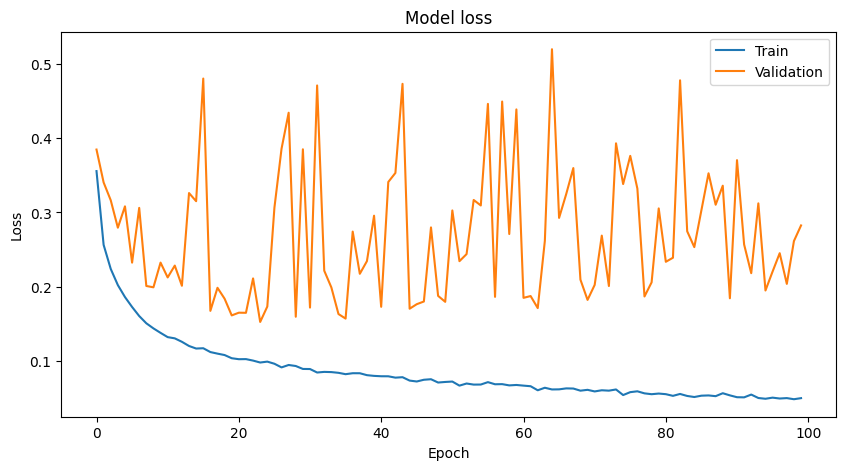

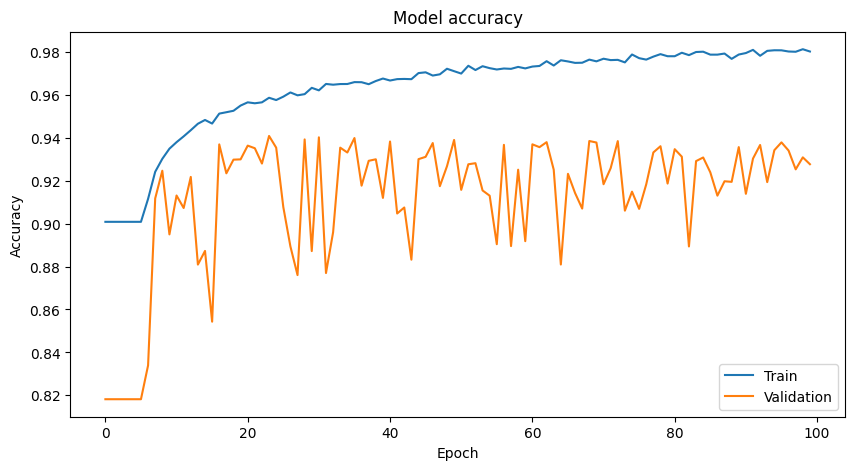

In [16]:
import matplotlib.pyplot as plt

# Plot training & validation loss values
plt.figure(figsize=(10, 5))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.show()

# Plot training & validation accuracy values
plt.figure(figsize=(10, 5))
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='lower right')
plt.show()